In [1]:
import glob
import urllib2
import qctoolkit as qtk
import numpy as np
import matplotlib.pyplot as plt
import copy

%matplotlib inline

/home/samio/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data construction for Alanates

In [2]:
unit = 'kj'

E_Ca = -0.390 # in eV from materials project
E_Sr = -0.419 # in eV from materials project
dE = qtk.convE(E_Ca - E_Sr, 'eV-%s' % unit)[0]
print dE

# raw input sorted by names
ref_raw = qtk.pload('ref.pkl')
pred_raw = qtk.pload('pred.pkl')

2.79807359426


Since E_Sr is lower, every Ca crystals need to be shifted upward by dE

In [3]:
# striping only experimental accessible Ca, Sr alanates
# ditching Mg related alanates

# for reference
ref_raw_all = []
ref_raw_ca = []
ref_raw_sr = []
for r in ref_raw:
    cyl, root = r.name.replace('.out', '').split('-')
    if 'Mg' not in cyl:
        if 'Mg' not in root:
            ref_raw_all.append(r)
        if 'Ca' in root:
            ref_raw_ca.append(r)
        if 'Sr' in root:
            ref_raw_sr.append(r)

# for prediction
pred_raw_all = []
pred_raw_ca = []
pred_raw_sr = []
for p in pred_raw:
    cyl, root = p.name.replace('out', '').split('-')
    if 'Mg' not in cyl and 'Mg' not in root:
        pred_raw_all.append(p)
        if '2Ca' in root:
            pred_raw_ca.append(p)
        if '2Sr' in root:
            pred_raw_sr.append(p)

In [4]:
print "total number of crystals: ",
print len(ref_raw_all)
print "Ca crystals: ",
print len(ref_raw_ca)
print "Sr crystals: ",
print len(ref_raw_sr)
print "native + swapped = 2*(native)\n"
print "total number of predictions: ",
print len(pred_raw_all)
print "(each reference crystal gets one prediction)"
print "native + swapped Ca crystals predicted by Sr: ",
print len(pred_raw_ca)
print "native + swapped Sr crystals predicted by Ca: ",
print len(pred_raw_sr)

total number of crystals:  172
Ca crystals:  86
Sr crystals:  86
native + swapped = 2*(native)

total number of predictions:  172
(each reference crystal gets one prediction)
native + swapped Ca crystals predicted by Sr:  86
native + swapped Sr crystals predicted by Ca:  86


In [5]:
# construct ordering key

def reorder_ref(outs):
    diffs = []
    for k in range(len(outs)):
        new = copy.deepcopy(outs[k])
        new.inUnit(unit)
        Z = np.array(new.molecule.Z)
        # number of H2 in the form of AlH4
        N = sum(np.ones(new.molecule.N)[Z==13])*(3./4.)
        new.Et = new.Et / N
        diffs.append(new)
    
    news = []
    order_key = np.argsort([r.Et for r in diffs])
    E_base = diffs[order_key[0]].Et
    for k in order_key:
        new = copy.deepcopy(diffs[k])
        new.Et = new.Et - E_base
        news.append(new)
    #for n in news:
    #    n.Et = n.Et - news[0].Et
    return news, order_key

def reorder_pred(outs, order_key):
    diffs = []
    for k in range(len(outs)):
        new = copy.deepcopy(outs[k])
        new.inUnit(unit)
        Z = np.array(new.molecule.Z)
        # number of H2 in the form of AlH4
        N = sum(np.ones(new.molecule.N)[Z==13])*(3./4.)
        new.Et = new.Et / N
        diffs.append(new)
        
    news = []
    E_base = diffs[order_key[0]].Et
    for k in order_key:
        new = copy.deepcopy(diffs[k])
        new.Et = new.Et - E_base
        news.append(new)
    return news
    

ref_sr, key_sr = reorder_ref(ref_raw_sr)
pred_sr = reorder_pred(pred_raw_sr, key_sr)

# shift Ca crystals by a constant difference
ref_ca, key_ca = reorder_ref(ref_raw_ca)
pred_ca = reorder_pred(pred_raw_ca, key_ca)
for i in range(len(ref_ca)):
    o = ref_ca[i]
    o.Et = o.Et + dE
    
    o = pred_ca[i]
    o.Et = o.Et + dE

In [6]:
ref_all_tmp = list(qtk.flatten([ref_sr, ref_ca]))
pred_all_tmp = list(qtk.flatten([pred_sr, pred_ca]))
key = np.argsort([r.Et for r in ref_all_tmp])

ref_all = []
pred_all = []
for k in key:
    ref_all.append(ref_all_tmp[k])
    pred_all.append(pred_all_tmp[k])
    
print len(ref_all)
print len(pred_all)

172
172


In [7]:
# reconstruction of ordered list
ref_ca = []
ref_sr = []
pred_ca = []
pred_sr = []
index_ca = []
index_sr = []
index_all = []
for i in range(len(ref_all)):
    index_all.append(i+1)
    r = copy.deepcopy(ref_all[i])
    p = copy.deepcopy(pred_all[i])
    elem = r.name.replace('.out', '').split('-')[-1]
    
    if elem == 'Sr':
        ref_sr.append(r)
        pred_sr.append(p)
        index_sr.append(i+1)
    elif elem == 'Ca':
        ref_ca.append(r)
        pred_ca.append(p)
        index_ca.append(i+1)

print len(ref_ca), len(ref_sr), len(index_ca), len(index_sr)

86 86 86 86


# Data construction for Ev

In [8]:
Ev_ref_raw = qtk.pload('Ev_ref.pkl')
Ev_pred_raw = qtk.pload('Ev_pred.pkl')

In [9]:
new_unit = 'ev'
for o in Ev_ref_raw:
    o.inUnit(new_unit)
for o in Ev_pred_raw:
    o.inUnit(new_unit)

In [10]:
freeAtom_Et = -168.33956386901738
Ev_ref = []
Ev_pred = []
for i in range(len(Ev_ref_raw)):
    o = Ev_ref_raw[i]
    op = Ev_pred_raw[i]
    if not np.isnan(o.Et) and not np.isnan(op.Et):
        Ev_ref.append(o.Et - freeAtom_Et)
        Ev_pred.append(op.Et - freeAtom_Et)

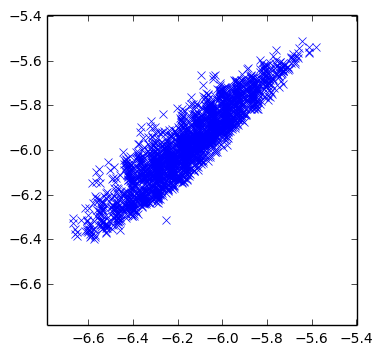

In [11]:
plt.plot(Ev_pred, Ev_ref, ls='', marker='x')
#plt.xlim(-176.5, -171)
ymax, ymin = np.max([Ev_ref, Ev_pred]), np.min([Ev_ref, Ev_pred])
pmax = ymax + 0.1 * (ymax - ymin)
pmin = ymin - 0.1 * (ymax - ymin)
plt.ylim([pmin, pmax])
plt.xlim([pmin, pmax])
plt.axes().set_aspect('equal')

In [12]:
key = np.argsort(Ev_ref)
Ev_pred_sorted = np.array(Ev_pred)[key]

# Data construction for Evp

In [13]:
Evp_ref_raw = qtk.pload('Evp_ref.pkl')
Evp_pred_raw = qtk.pload('Evp_pred.pkl')

In [14]:
Evp_ref = [o.Et for o in Evp_ref_raw]
Evp_pred = [o.Et for o in Evp_pred_raw]

# Combined plot for publication purpose

In [15]:
# construct plot data
Er_ca = [o.Et for o in ref_ca]
Er_sr = [o.Et for o in ref_sr]
Er_all = [o.Et for o in ref_all]
Ep_ca = [o.Et for o in pred_ca]
Ep_sr = [o.Et for o in pred_sr]
Ep_all = [o.Et for o in pred_all]


#Er_Ev = [o.Et for o in Ev_ref]
#Ep_Ev = [o.Et for o in Ev_pred]
Er_Ev = sorted(Ev_ref)
Ep_Ev = Ev_pred_sorted
index_Ev = range(1, len(Er_Ev) + 1)

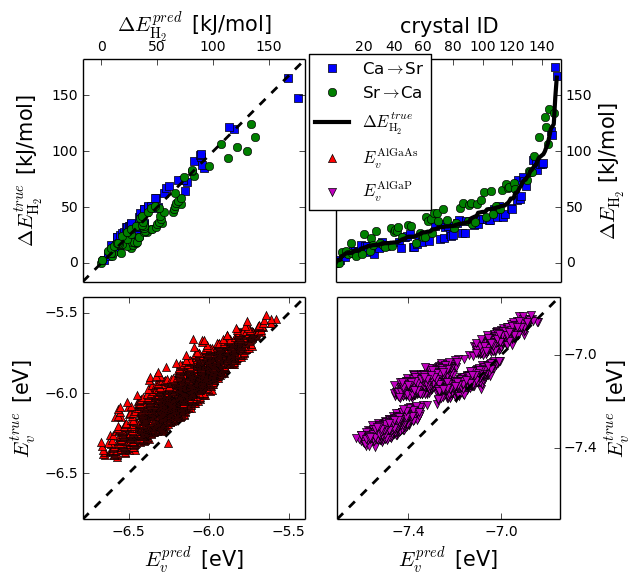

In [17]:
N = 150
Nv = len(Er_Ev)
Nva = len(Evp_ref)

p_max = max(Er_all[:N])
p_min = min(Er_all[:N])
y_min = float(p_min - (p_max - p_min) / 10.)
y_max = float(p_max + (p_max - p_min) / 10.)

fig, ((ax_scatter, ax_order), (ax_scatter_Ev, ax_order_Ev)) = plt.subplots(2,2, figsize=(7, 6))


ax_order.plot(index_ca, Ep_ca, ls='', marker='s', label=r'Ca$\rightarrow$Sr')
ax_order.plot(index_sr, Ep_sr, ls='', marker='o', label=r'Sr$\rightarrow$Ca')
ax_order.plot(index_all[:N], Er_all[:N], ls='-', color='k', lw=3, label=r'$\Delta E_{\mathrm{H}_2}^{true}$')
ax_order.plot(1000, 1000, color='r', marker='^', label=r'$E_v^{\mathrm{AlGaAs}}$', ls='')
ax_order.plot(1000, 1000, color='m', marker='v', label=r'$E_v^{\mathrm{AlGaP}}$', ls='')
ax_order.set_xlabel('crystal ID', fontsize=15)
ax_order.set_ylabel('$\Delta E_{\mathrm{H}_2}$ [kJ/mol]', fontsize=15)
ax_order.yaxis.tick_right()
ax_order.yaxis.set_label_position("right")
ax_order.xaxis.tick_top()
ax_order.xaxis.set_label_position("top")
ax_order.set_xlim([1, N+3])
ax_order.set_ylim([y_min, y_max])
ax_order.legend(loc=(-0.12, 0.32), numpoints=1)
ax_order.set_zorder(100)
ax_order.set_aspect(float(N)/(y_max - y_min))

ax_scatter.plot(Ep_ca[:N], Er_ca[:N], ls='', marker='s')
ax_scatter.plot(Ep_sr[:N], Er_sr[:N], ls='', marker='o')
ax_scatter.plot([y_min, y_max], [y_min, y_max], color='k', ls='--', lw=2)
ax_scatter.set_aspect('equal')
ax_scatter.set_xlim(y_min, y_max)
ax_scatter.set_ylim(y_min, y_max)
ax_scatter.xaxis.tick_top()
ax_scatter.xaxis.set_label_position("top")
ax_scatter.set_ylabel('$\Delta E_{\mathrm{H}_2}^{true}$ [kJ/mol]', fontsize=15)
ax_scatter.set_xlabel('$\Delta E_{\mathrm{H}_2}^{pred}$ [kJ/mol]', fontsize=15)
#ax_scatter.legend(loc=4, numpoints=1)

pp_max = max(max(Evp_ref[:Nva]), max(Evp_pred[:Nva]))
pp_min = min(min(Evp_ref[:Nva]), min(Evp_pred[:Nva]))
yp_min = float(pp_min - (pp_max - pp_min) / 10.)
yp_max = float(pp_max + (pp_max - pp_min) / 10.)

ax_order_Ev.plot(Evp_pred[:Nva], Evp_ref[:Nva], ls='', marker='v', color='m')
ax_order_Ev.plot([yp_min, yp_max], [yp_min, yp_max], color='k', ls='--', lw=2)
ax_order_Ev.set_aspect('equal')
ax_order_Ev.set_xticks(np.arange(round(yp_min)-1, round(yp_max)+1, 0.4))
ax_order_Ev.set_yticks(np.arange(round(yp_min)-1, round(yp_max)+1, 0.4))
ax_order_Ev.set_xlim(yp_min, yp_max)
ax_order_Ev.set_ylim(yp_min, yp_max)
ax_order_Ev.yaxis.tick_right()
ax_order_Ev.yaxis.set_label_position("right")
ax_order_Ev.set_ylabel('$E_v^{true}$ [eV]', fontsize=15)
ax_order_Ev.set_xlabel('$E_v^{pred}$ [eV]', fontsize=15)

pa_max = max(max(Er_Ev[:Nv]), max(Ep_Ev[:Nv]))
pa_min = min(min(Er_Ev[:Nv]), min(Ep_Ev[:Nv]))
p_max = max(pa_max, pp_max)
p_min = min(pa_min, pp_min)
# y_min = float(p_min - (p_max - p_min) / 10.)
# y_max = float(p_max + (p_max - p_min) / 10.)
y_max = float(pa_max + 0.1*(pa_max - pa_min))
y_min = float(pa_min - 0.1*(pa_max - pa_min))


ax_scatter_Ev.plot(Evp_pred[:Nva], Evp_ref[:Nva], ls='', marker='v', color='m')
ax_scatter_Ev.plot([y_min, y_max], [y_min, y_max], color='k', ls='--', lw=2)
ax_scatter_Ev.plot(Ep_Ev[:Nv], Er_Ev[:Nv], ls='', marker='^', color='r')
ax_scatter_Ev.set_aspect('equal')
ax_scatter_Ev.set_xticks(np.arange(round(y_min), round(y_max), 0.5))
ax_scatter_Ev.set_yticks(np.arange(round(y_min), round(y_max), 0.5))
ax_scatter_Ev.set_xlim(y_min, y_max)
ax_scatter_Ev.set_ylim(y_min, y_max)
ax_scatter_Ev.set_ylabel('$E_v^{true}$ [eV]', fontsize=15)
ax_scatter_Ev.set_xlabel('$E_v^{pred}$ [eV]', fontsize=15)

plt.tight_layout(w_pad=-1)

fig.savefig('order_plot.pdf', bbox_inches='tight')

In [76]:
x1, y1 = Er_ca[:N], Ep_ca[:N]
x2, y2 = Er_sr[:N], Ep_sr[:N]
x12 = np.concatenate([x1, x2])
y12 = np.concatenate([y1, y2])

x3, y3 = Er_Ev[:Nv], Ep_Ev[:Nv]
x4, y4 = Evp_ref[:Nva], Evp_pred[:Nva]
x34 = np.concatenate([x3, x4])
y34 = np.concatenate([y3, y4])


def fit(x, y):
    yp = qtk.ML.l2_fit(x, y)
    R, _, mae = qtk.ML.error_measure(y, yp)
    return R, mae

print "(R2, mae)"
print fit(x1, y1)
print fit(x2, y2)
print fit(x12, y12)
print fit(x3, y3)
print fit(x4, y4)
print fit(x34, y34)

(R2, mae)
(0.97546688390569025, 5.1065928717958871)
(0.96177868556318802, 8.3701508174413046)
(0.96159205807950898, 8.2028362785635291)
(0.60177223202853947, 0.063771622723547888)
(0.66617842884732759, 0.056056917241753358)
(0.87267982468478311, 0.068217602123124776)
